<a href="https://colab.research.google.com/github/prog815/portfOptim/blob/master/%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BF%D0%BE_%D0%A8%D0%B0%D1%80%D0%BF%D1%83_%D0%B1%D0%B5%D0%B7_%D0%B4%D0%B5%D0%BD%D0%B5%D0%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [ ]:
! pip install bt
! pip install git+https://github.com/prog815/progGA

     |████████████████████████████████| 2.7MB 3.4MB/s 
  Created wheel for bt: filename=bt-0.2.7-cp36-cp36m-linux_x86_64.whl size=533294 sha256=fa402eaab8e1b344a4f65c48ca1fcc8fde644dd2dbe865f50a0bee783e10f1c0
  Stored in directory: /root/.cache/pip/wheels/ae/8a/a2/a679757e4e7219e6f17727d1422d4ce32da847678c6559da35
  Created wheel for ffn: filename=ffn-0.3.4-cp36-none-any.whl size=22813 sha256=9f11b4688e5159912d57c067ec48f7f48b242e055b8ff9312ddfb206f65f4b69
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
Successfully built bt ffn
  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-r21ctviu
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-r21ctviu
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3733 sha256=75b039c55c5f6655a46b1f849e7a30d5129ece945911275c893a0318ad282c08
  Stored in directory: /tmp/pip-ephem-wheel-cache-7pxmernd/wheels/9c/7a/cc/d1ffa9ccaa42b

In [ ]:
import bt
from progGA import ListGenetic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings

fn = '/content/drive/My Drive/prog/model_dpswm_31.10.2020.pkl'

/usr/local/lib/python3.6/dist-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


# Загрузка истории

In [ ]:
data = bt.get('AAPL,AAL,GE,F',start='2010-01-01')
lenData = len(data)
data

,aapl,aal,ge,f
Date,,,,
2010-01-04,6.604801,4.496876,10.715343,7.238358
2010-01-05,6.616219,5.005957,10.770829,7.717158
2010-01-06,6.510980,4.798555,10.715343,8.005848
2010-01-07,6.498945,4.939965,11.270185,8.210042
2010-01-08,6.542150,4.845690,11.512927,8.231167
...,...,...,...,...
2020-10-26,115.050003,11.800000,7.380000,8.030000
2020-10-27,116.599998,11.230000,7.100000,7.920000
2020-10-28,111.199997,10.950000,7.420000,7.700000


# Алгоритм распределения

In [ ]:
dd = data.to_returns().copy()

r = bt.ffn.calc_mean_var_weights(dd[-10:])
type(r)

pandas.core.series.Series

In [ ]:
def predWeights(d,lookback=10,lag=10,learnLen=300,reg = 0.0001,min_delta = 0.001,lr=0.0001,hl=100,doRate=0.5):

    n = d.shape[1]
    
    X = pd.concat([d.shift(lag+n) for n in range(1,lookback+1)],axis=1)
    #y = d.rolling(lag).mean().shift(1-lag)
    
    y = d.copy()
    def calc_mean_var_weights(data):
        try:
            res = bt.ffn.calc_mean_var_weights(data)
        except Exception:
            res = y[-1].copy() / n
        return res

    y[-lag-learnLen-1:] = d[-lag-learnLen-1:].rollapply(window=lag,fn=calc_mean_var_weights)
    y = y.shift(1-lag)

    xy = pd.concat([y,X],axis=1).dropna()

    y = xy.iloc[-learnLen:,:n]
    X = xy.iloc[-learnLen:,n:]
    
    # def loss_function(y_true, y_pred):
    #     return tf.nn.relu(tf.math.reduce_mean(y_true,axis=1))-tf.math.reduce_sum(y_true * y_pred[:,:-1],axis=1)

    model = keras.Sequential([layers.Dense(hl,activation='sigmoid',input_shape=(X.shape[1],),kernel_regularizer=keras.regularizers.l2(reg)),
                              layers.Dropout(doRate),
                              layers.Dense(n,activation='softmax',kernel_regularizer=keras.regularizers.l2(reg))
                              ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),loss=keras.losses.mse)
    
    learn_res = model.fit(X, y, 
                          epochs=1000,
                          validation_split=0.2,
                          verbose=False,
                          use_multiprocessing=True,
                          callbacks=[keras.callbacks.EarlyStopping('val_loss',min_delta=min_delta,patience=10)])
    
    X = pd.concat([d.shift(n) for n in range(0,lookback)],axis=1)
    weights = model.predict(X)[-1]

    return weights

dData = data.to_returns()
t=1000

for n in range(10):
    weights = predWeights(dData[:t])
    print(weights,1-sum(weights))


[0.25853637 0.30467135 0.1632425  0.2735498 ] -1.4901161193847656e-08
[0.17588003 0.39387065 0.2220761  0.20817326] -4.470348358154297e-08
[0.19032823 0.2972064  0.24093178 0.27153355] 4.470348358154297e-08
[0.2448451  0.3775779  0.05043028 0.32714674] -2.9802322387695312e-08
[0.27230564 0.32434312 0.28778645 0.11556482] -2.9802322387695312e-08
[0.16717525 0.28405416 0.26435703 0.28441355] 1.4901161193847656e-08
[0.18320343 0.36801618 0.18067397 0.26810646] -4.470348358154297e-08
[0.1639374  0.30013928 0.26157093 0.2743524 ] -1.4901161193847656e-08
[0.25722593 0.25729454 0.22173536 0.26374415] 2.9802322387695312e-08
[0.17809947 0.28172272 0.2465734  0.29360446] -5.960464477539063e-08


In [ ]:
class WeighPredTF(bt.Algo):
    def __init__(self, lookback, learnLen, reg, min_delta, lr, hl, lag, doRate):
        super(WeighPredTF, self).__init__()

        self.lookback = lookback
        self.learnLen = learnLen
        self.reg = reg
        self.min_delta = min_delta
        self.lr = lr
        self.hl = hl
        self.lag = lag
        self.doRate = doRate

    def __call__(self, target):
        
        selected = target.temp['selected']
        n = len(selected)

        if n == 0:
            target.temp['weights'] = {}
        else:
            w = 1.0 / n
            target.temp['weights'] = {x: w for x in selected}
        
        d = target.universe[selected].to_returns()
        
        weights = predWeights(d,
                              lookback=self.lookback,
                              lag=self.lag,
                              learnLen=self.learnLen,
                              reg=np.power(10,self.reg),
                              min_delta=np.power(10,self.min_delta),
                              lr=np.power(10,self.lr),
                              hl=self.hl,
                              doRate=self.doRate)

        target.temp['weights'] = pd.Series({d.columns[i]: weights[i] for i in range(n)}).dropna()
        
        return True

# Поиск гиперпараметров

## Целевая функция

In [ ]:
def getQualityMethod(lookback,learnLen,reg,min_delta,lr,hl,lag,doRate):

    t = np.random.randint(2*lag+learnLen+lookback+1,lenData-1-2*lag)
    #print('t=',t)
    
    weights = predWeights(dData[:t],
                          lookback=lookback,
                          lag=lag,
                          learnLen=learnLen,
                          reg=np.power(10,reg),
                          min_delta=np.power(10,min_delta),
                          lr=np.power(10,lr),
                          hl=hl,
                          doRate=doRate)
    # print(weights)

    d = dData[t:(t+lag)]                # данные
    
    p = sum(d.mean().values*weights)    # на прогнозе среднее
    m = d.values.mean()                 # на курсах среднее
    v = abs(d.values).mean()            # на модулях изменений среднее
    
    # raise Exception()

    return (p-m)/v

## Создание модели

In [ ]:
modelGA = ListGenetic(pop_size=200,
                      lookback=range(30,200),
                      learnLen=range(50,500),
                      reg=np.arange(-7.0,-0.5,0.01),
                      min_delta=np.arange(-7.0,-0.5,0.01),
                      lr=np.arange(-7.0,-0.1,0.01),
                      hl=range(10,1000),
                      lag=range(10,200),
                      doRate=np.arange(0.01,1.0,0.01),
                      quality_method=getQualityMethod)

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

## Бесконечный цикл поиска

In [ ]:
import logging
logging.getLogger('tensorflow').disabled = True

while True:
    modelGA.fit(10,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

finish -  16152 {'quality': 0.31055410498766106, 'lookback': 188, 'learnLen': 170, 'reg': -4.460000000000054, 'min_delta': -1.8100000000001106, 'lr': -2.0900000000001047, 'hl': 266, 'lag': 35, 'doRate': 0.99}
finish -  16162 {'quality': -0.2019523015688643, 'lookback': 199, 'learnLen': 128, 'reg': -4.18000000000006, 'min_delta': -1.8200000000001104, 'lr': -1.3300000000001209, 'hl': 283, 'lag': 41, 'doRate': 0.97}
finish -  16172 {'quality': 0.15407012636463138, 'lookback': 195, 'learnLen': 169, 'reg': -3.5400000000000738, 'min_delta': -2.170000000000103, 'lr': -1.650000000000114, 'hl': 376, 'lag': 72, 'doRate': 0.98}
finish -  16182 {'quality': -0.03142116781455536, 'lookback': 199, 'learnLen': 150, 'reg': -4.320000000000057, 'min_delta': -1.6400000000001143, 'lr': -1.3500000000001204, 'hl': 240, 'lag': 67, 'doRate': 0.99}
finish -  16192 {'quality': 0.14170313665350853, 'lookback': 191, 'learnLen': 163, 'reg': -3.9300000000000654, 'min_delta': -1.790000000000111, 'lr': -2.020000000000

ResourceExhaustedError: ignored

## Графики

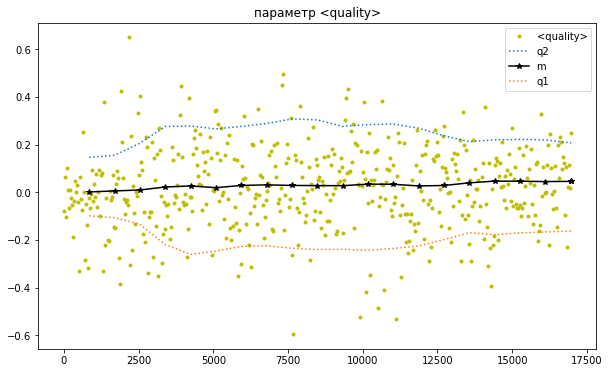

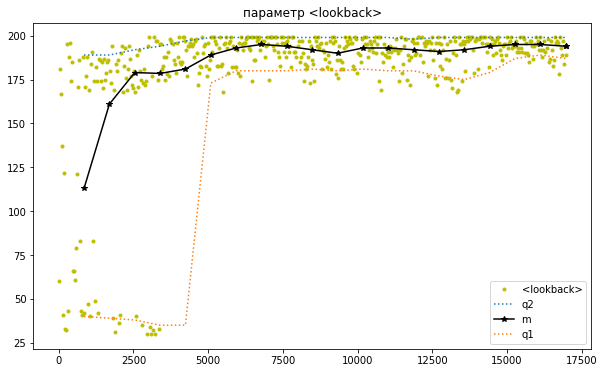

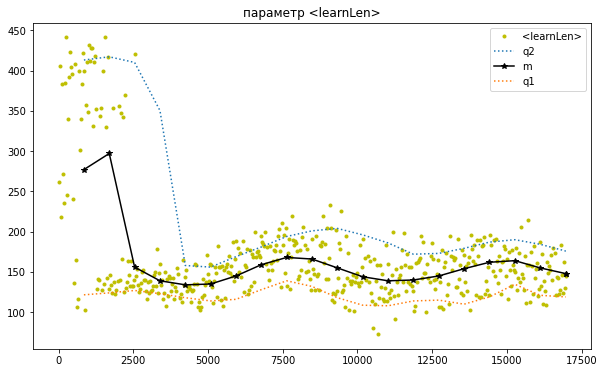

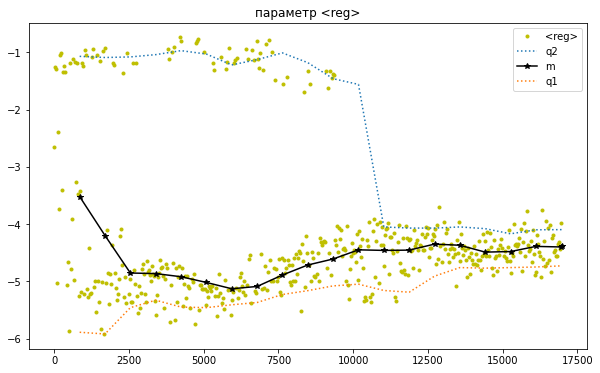

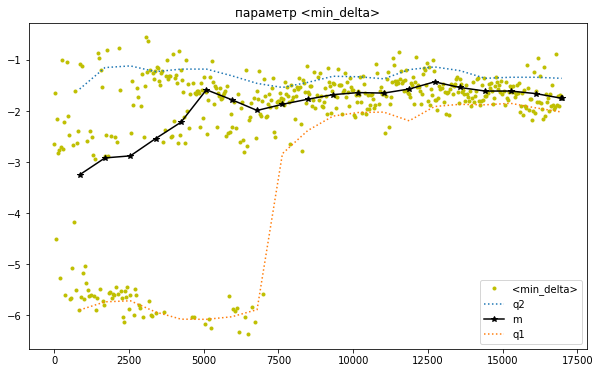

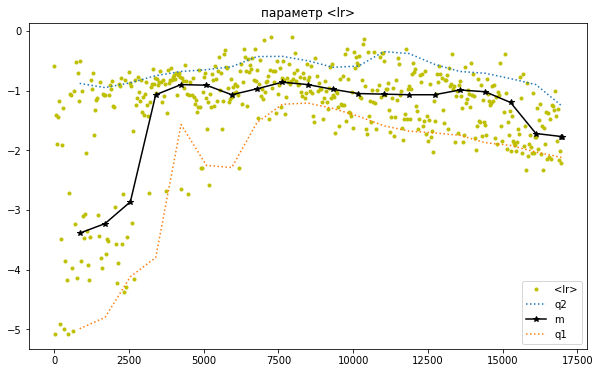

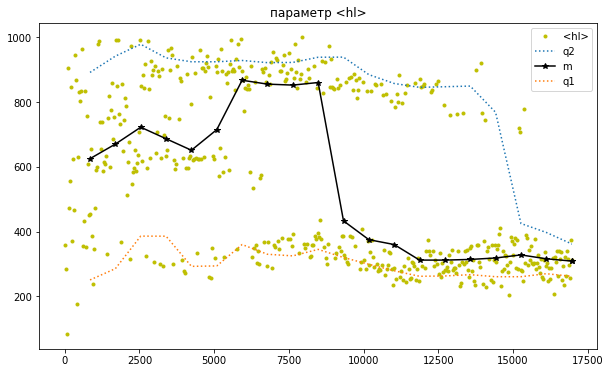

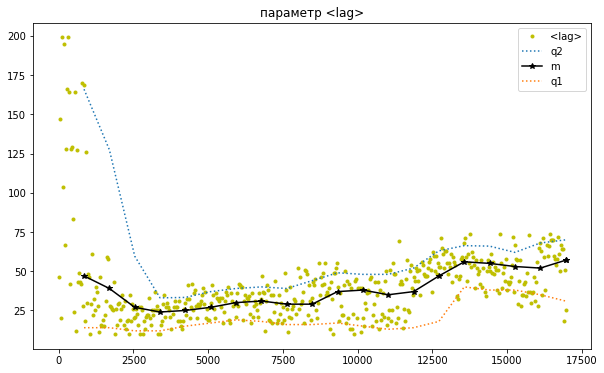

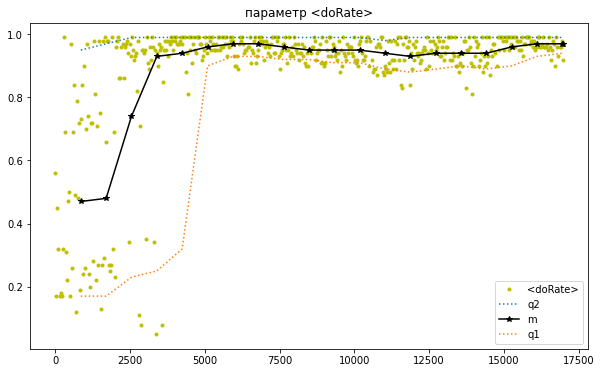

In [ ]:
modelGA.plot_hist_new(('quality','lookback','learnLen','reg','min_delta','lr','hl','lag','doRate'))


## Параметры лучшей

In [ ]:
best_par = modelGA.getBestParams()
best_par

{'doRate': 0.9600000000000001,
 'hl': 322,
 'lag': 52,
 'learnLen': 149,
 'lookback': 194,
 'lr': -1.650000000000114,
 'min_delta': -1.7300000000001123,
 'reg': -4.330000000000057}

# Прогон лучшей

In [ ]:
lookback_best = best_par['lookback']
lag_best = best_par['lag']
learnLen_best = best_par['learnLen']
reg_best = best_par['reg']
min_delta_best = best_par['min_delta']
lr_best = best_par['lr']
hl_best = best_par['hl']
doRate_best = best_par['doRate']

s_best = bt.Strategy('лучший', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best*2+learnLen_best+lookback_best+1),
                                bt.algos.SelectAll(),
                                WeighPredTF(lookback=lookback_best,
                                            learnLen=learnLen_best,
                                            reg=reg_best,
                                            min_delta=min_delta_best,
                                            lr=lr_best,
                                            hl=hl_best,
                                            lag=lag_best,
                                            doRate=doRate_best),
                                bt.algos.Rebalance()])
test_best = bt.Backtest(s_best, data)

s0 = bt.Strategy('равновесный', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best+learnLen_best+lookback_best+1),
                                 bt.algos.SelectAll(),
                                 bt.algos.WeighEqually(),
                                 bt.algos.Rebalance()])
test0 = bt.Backtest(s0, data)

res_best = bt.run(test_best,test0)

лучший
0% [############################# ] 100% | ETA: 00:00:03равновесный
0% [############################# ] 100% | ETA: 00:00:00

## График баланса

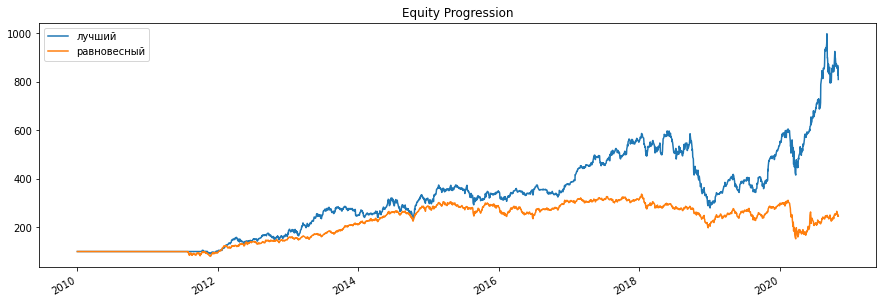

In [ ]:
res_best.plot()

## график распределения долей

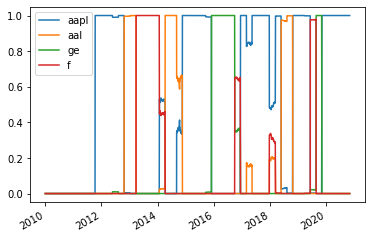

In [ ]:
res_best.get_security_weights().plot()

## график распределения свободной доли

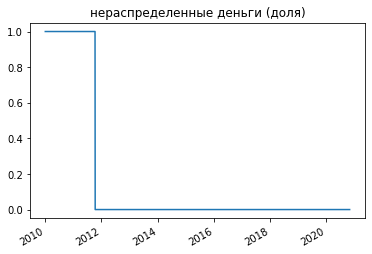

In [ ]:
w = res_best.get_weights(0)
w['деньги'] = 1-w.values[:,1:].sum(axis=1)
w['деньги'].plot()
plt.title('нераспределенные деньги (доля)')
del(w)

## итог

In [ ]:
res_best.display()

Stat                 лучший      равновесный
-------------------  ----------  -------------
Start                2010-01-03  2010-01-03
End                  2020-10-30  2020-10-30
Risk-free rate       0.00%       0.00%

Total Return         709.51%     146.54%
Daily Sharpe         0.84        0.46
Daily Sortino        1.38        0.73
CAGR                 21.32%      8.69%
Max Drawdown         -53.22%     -54.71%
Calmar Ratio         0.40        0.16

MTD                  -6.00%      5.82%
3m                   13.38%      15.17%
6m                   48.88%      31.01%
YTD                  49.31%      -15.32%
1Y                   84.63%      -7.84%
3Y (ann.)            14.90%      -7.34%
5Y (ann.)            18.99%      -3.59%
10Y (ann.)           23.27%      9.45%
Since Incep. (ann.)  21.32%      8.69%

Daily Sharpe         0.84        0.46
Daily Sortino        1.38        0.73
Daily Mean (ann.)    23.07%      11.36%
Daily Vol (ann.)     27.35%      24.60%
Daily Skew           0.08    

Енин А.В.

Оренбург